# Is this me or is it my twin sister?

## tl; dr
I trained a k-NN model to differentiate between my twin sister and me in a collection of childhood photos. Facial features in the input images were identified using dlib's facial landmarks recognition and then represented numerically as 128-dimensional vectors through a pre-trained Residual Neural Network model. I used grid search to optimize the model hyperparameters and assessed the binary classification using two metrics: accuracy and precision, each aligned with a slightly different problem formulation. The model does not perform well in respect to either of the measures, proving my point that my sister and I were indistinguishable as children.

## 0. Motivation

A couple of years ago (back when it was cool), I threw a bunch of funny childhood photos of me up on my Instagram.

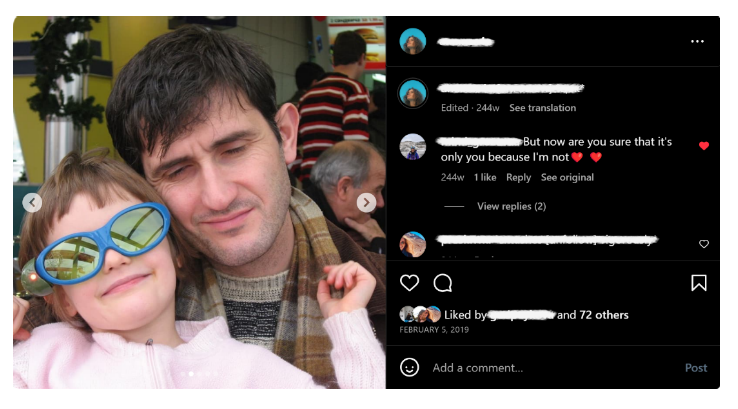

The very first comment from a friend commented went something like this:
> But are you sure that it's only you because I'm not🧡

Maybe this is a good moment to say that I have a twin sister. Yes, we're identical. Yes, people have a tough time telling us apart. But come on, it's not that hard. And obviously, I'm the one in these photos - who else but me could possibly differentiate between my sister and me?

I found the comment funny, shared it with my mom and showed her the pictures. And... turns out out of the five photos I posted three were actually my sister's, not mine. 40% success rate.


That was slightly embarrassing. But in my defense, we looked incredibly alike when we were little. Was it even possible to tell us apart? I'm thinking of training a machine learning model to do the job for me. If I succeed, I can just pick a childhood photo, feed it into the model and determine if it is me or not, without looking stupid and consulting my mom. If I fail, it'll just prove that it wasn't entirely my fault; we were just *that* similar. So, it's a win-win situation - now let's get to the job.

## 1. Problem Statement

The goal is to select and train a model that takes images of faces as input and classifies them in two categories: “me” or “not me”. In other words — binary classification of facial photos.

## 2. Data

### 2.1. Dataset

To train a classification model like this, I needed to gather a dataset containing childhood photos where both my face and my sister's were clearly visible and have someone (more reliable than me) to label them. My parents took on both tasks and in less than 12 hours, they sent me a batch of 52 photos of either me, my sister or the two of us together. They did very well, but I had to remove a few images from the dataset. In some photos, either the face wasn't directly aimed at the camera or the facial expression was too different from neutral or smiling. Given the relatively small dataset, I wanted to keep things simple and only work with "clean" data: well-lit, directly facing the camera and free from any obstructions.

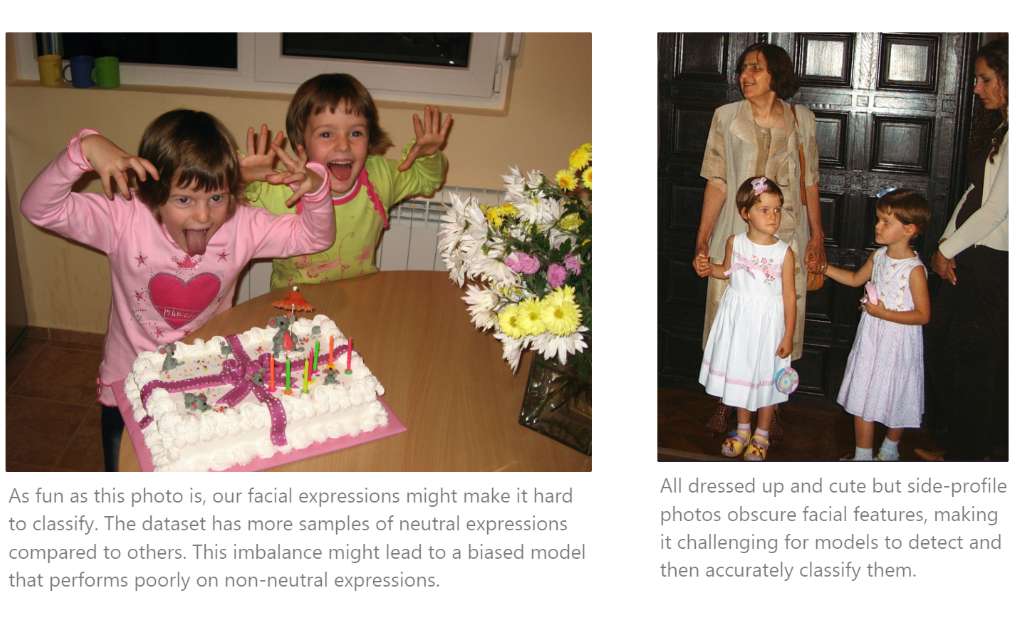


After filtering out the unsuitable photos, I used the labels my mom provided to spliy the images into two sets. To make the labeling process and face recognition easier, I cropped out all other faces from the photos (sorry Grandma!). I cut the photos of both my sister and me in two, allocating each half to its respective subset. In the end, I had 44 photos of me and 42 of my sister, creating a well-balanced dataset.


Next up, data pre-processing.

### 2.2. Preprocessing: Feature Extraction

I wanted to focus solely on the faces in the photos, eliminating all other elements like background or other details. I also needed to find a way to represent image data (pixels) in a compact and computationally comparable way.

For this I used `dlib`, a machine learning library for object recognition, especially well developed to work with faces. It is written in C++ but offers Python bindings. While less accurate on noisy datasets than computationally intensive alternatives like MTCNN, `dlib` excels in well-lit frontal-facing portrait photos.


Processing the data using `dlib` is three-fold. The first one is explained (intuitively) below; the second and third are beyond the scope of this assignment and are briefly outlined.

1. **Face Detecion**

    The input image is converted to grayscale and pixel values are normalized. Then `dlib` uses a Histogram of Oriented Gradients (HOG) feature descriptor to extract edge and texture information. HOG computes the gradients in the image, which represent how quickly pixel values (in grayscale possible values are from 0 to 255) change in different directions. Around edges (where one object transitions to another), pixels are expected to change abrubtly. The gradients are then quantized into several bins according to orientation. The resulting bins indicate the predominant directions of intensity changes in local parts of the image. The collection of these bins is a histogram showing the local distribution of gradient directions. These histograms collectively represent the object's texture and shape.


    These HOG alogorithm-generated histograms serve as features and are fed into a pre-trained linear classifier, which has learned patterns from a large dataset of labeled face images. This classifier uses a sliding window detector, systematically scanning the image at different scales and positions. At each window position, the HOG features are extracted and evaluated. If the patterns match those typical of a face, the detector identifies the window as containing a face.

2. **Facial Landmark Placement**

    After detecting the face, the landmark detection algorithm places 68 reference points outlining facial contours ("landmarks") — eyes, eyebrows, nose, mouth and face outline. 


    In this case, I used a pre-trained facial landmarks detector model provided by the dlib library (see Resources).


3. **Creating a Face Embedding**

    The 68 points serve as a spatial reference for the deep learning model underlying the face recognition process. Based on the spatial relationships between the points, the model creates a 128-dimensional face embedding.

    *Embedding* here refers to a vector in a 128-dimensional space. Each dimension signifies a distinct facial feature, though these features aren't human-interpretable.


    In this case, I used a pre-trained residual neural network model with 29 convolutional layers created by Davis King (see Resources). It was trained on a dataset comprising 3 million faces collected from various sources achieving a mean error of 99.38%, indicating effectiveness in face recognition tasks.

To sum up, `dlib`’s face detection and embedding generation models take a photo as input and if a face is found in it, the output is its numerical representation. This is exactly what I needed as the outputs are 1) computer-legible (numbers!), and 2) easy to compare.

The similarity between two faces is the distance between their two vectors. In this case, I decided to use the L2 distance, aka the Euclidean distance that we all know from high school, because it is a simple and easy to interpret scalar value that captures the differences across all features. In the context of face embeddings, Euclidean distance is the sum of the differences between the 128 pairs of features of 2 faces. If two face embeddings are similar, their Euclidean distance will be small; if they are not, the distance will be large.

In [ ]:
# To install dlib, you need to satisfy some dependencies first (download and install C++ compiler in Visual Studio and CMake)
# I followed this tutorial: https://www.geeksforgeeks.org/how-to-install-dlib-library-for-python-in-windows-10/
%pip install cmake
%pip install dlib
%pip install opencv-python
%pip install imutils

# Encountered a bug with knn, fixed following this: https://github.com/scikit-learn/scikit-learn/issues/26768
%pip uninstall scikit-learn
%pip install scikit-learn==1.2.2

In [2]:
import os
import dlib
import cv2
import imutils
from imutils import face_utils

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

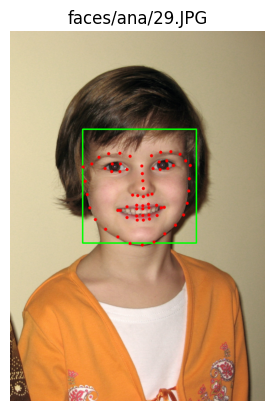

In [3]:
# code adapted from https://colab.research.google.com/drive/1ISCmkPHE8Dm-MuHijRuJeidqO-QrPnTz?usp=sharing#scrollTo=VJaCNlDDRz6d

# for this, you'll need to download the predictor model from
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 
# then extract and place in the project folder

photo = "faces/ana/29.JPG"

def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.axis("off")
	plt.show()
	
# initialize dlib's face detector (HOG-based)
# create the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# load, resize and convert to grayscale
image = cv2.imread(photo)
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
	# determine the facial landmarks for the face region
	shape = predictor(gray, rect)

	# convert the facial landmark (x, y)-coordinates to a NumPy array
	shape = face_utils.shape_to_np(shape)

	# convert dlib's rectangle to a OpenCV-style bounding box
	(x, y, w, h) = face_utils.rect_to_bb(rect)

	# draw the bounding box
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

	# and draw facial landmarks on the image using their (x, y)-coordinates
	for (x, y) in shape:
		cv2.circle(image, (x, y), 3, (0, 0, 255), -1)

plt_imshow(f"{photo}", image)

This is what a face's landmarks mapping looks like. Numerically, it is a list (NumPy array) with 68 lists, each containing the x,y-coordinates of one of the reference points.  As of now, the x,y-coordinates are not normalized and are very specific to each photo. So, their Euclidean distance would correspond to the location and size of the face within the photo rather than the actual facial features.

In dlib, the get_face_chip function is used to extract a standardized facial region known as a "chip" from an input image. It aligns the face in the input image, scales it to a predefined size and crops the face region. The resulting face chip is needed to complete the final part of the pre-processing: extracting facial embeddings. Before going there, however, let' s derive the facial landmarks and face chips for all photos in the dataset.

In [4]:
# wrapping it into a nice function

# for this, you'll need to download the predictor model from
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 
# then extract and place in the project folder

def get_reference_points(folder_path, shape_predictor = "shape_predictor_68_face_landmarks.dat"):
	'''
    This function uses dlib's face detection and shape prediction to locate and extract
    facial landmarks from images in the specified folder. It resizes the images for processing,
    converts them to grayscale, then applies face detection and shape prediction models.
    The function returns the coordinates of facial landmarks (68 points) for each detected face
    in the images along with their corresponding filenames. If no face is detected in a photo, the
	filename is printed and the photo is skipped. If more than one face is detected, the filename
	is printed and the photo is skipped.

    Parameters:
        folder_path (str): Path to the folder containing front-facing photos.
        predictor_path (str): Path to the shape predictor model file. Default is set to 'shape_predictor_68_face_landmarks.dat'. Make sure the file is in the project directory.

    Returns:
        shapes (list): A list of NumPy arrays, each containing the coordinates of 68 facial landmarks for a detected face in an image.
        files (list): A list of filenames corresponding to the images with detected faces.
	'''
	# initialize dlib's frontal face detector (HOG) based
	detector = dlib.get_frontal_face_detector()
	# create a 68-point landmark detector from file 
	predictor = dlib.shape_predictor(shape_predictor)

	shapes = []
	chips = []
	files = []

	print(f'ANALYZING PHOTOS IN "{folder_path}" \n ---')

	# iterate through the files in the folder
	for file in os.listdir(folder_path):
		if file.endswith('.JPG'): # filter out non-image files
			photo_path = os.path.join(folder_path, file)
			image = cv2.imread(photo_path)
			image = imutils.resize(image, width=500)

			# convert to grayscale for simpler processing
			gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

			rects = []
			rects = detector(gray, 1)

			# if exactly 1 face is detected
			if len(rects) == 1:
			# loop over the faces detected
				for rect in rects:
					# determine facial landmarks & convert (x, y)-coordinates to a NumPy array
					shape = predictor(gray, rect)
					chip = dlib.get_face_chip(image, shape)
					shape = face_utils.shape_to_np(shape)

					shapes.append(shape)
					chips.append(chip)
					files.append(file)
			elif rects:
				print(f'Multiple faces detected in {file}.')
			else:
				print(f'No face detected in {file}.')

	print(f'--- \n {len(shapes)} FACES FOUND IN FOLDER \n')			
	return shapes, chips, files

In [5]:
%%time
shapes_ana, chips_ana, files_ana = get_reference_points('faces/ana')
shapes_geri, chips_geri, files_geri = get_reference_points('faces/geri')

ANALYZING PHOTOS IN "faces/ana" 
 ---
No face detected in 13.JPG.
No face detected in 14.JPG.
No face detected in 20.JPG.
No face detected in 26.JPG.
No face detected in 27.JPG.
No face detected in 34.JPG.
No face detected in 38.JPG.
--- 
 37 FACES FOUND IN FOLDER 

ANALYZING PHOTOS IN "faces/geri" 
 ---
Multiple faces detected in 21.JPG.
Multiple faces detected in 25.JPG.
--- 
 40 FACES FOUND IN FOLDER 

CPU times: total: 16.2 s
Wall time: 24.1 s


After facial detection, the two datasets have 37 and 40 photos respectively as the algorithm did not detect faces in some of the photos. I also made it omit photos where multiple faces were detected as these are false positives (I manually deleted such photos already, so the algorithms is picking up on something that is not a face). This does not reduce the dataset significantly, so I decided to roll with it.


There is one last step left in the preprocessing part, which is converting the facial landmarks into face embeddings. I did this using Davis King's pre-trained ResNet model.

In [6]:
%%time

# for this, you'll need to download the pre-trained model from
# https://github.com/davisking/dlib-models#dlib_face_recognition_resnet_model_v1datbz2
# then extract and place in the project folder
face_encoder = dlib.face_recognition_model_v1("dlib_face_recognition_resnet_model_v1.dat")

embeddings_ana = []
embeddings_geri = []

for chip in chips_ana:
    embedding = face_encoder.compute_face_descriptor(chip)
    embeddings_ana.append(embedding)

for chip in chips_geri:
    embedding = face_encoder.compute_face_descriptor(chip)
    embeddings_geri.append(embedding)

CPU times: total: 20.1 s
Wall time: 22.3 s


Finally, I put together the embeddings into a dataframe with their corresponding labels.

In [7]:
columns = np.arange(0,128) # column names for my features

vectors_ana = np.array([np.array(vector) for vector in embeddings_ana])
df_ana = pd.DataFrame(vectors_ana, columns=columns)
df_ana['label'] = 'Ana'

vectors_geri = np.array([np.array(vector) for vector in embeddings_geri])
df_geri = pd.DataFrame(vectors_ana, columns=columns)
df_geri['label'] = 'Geri'

# combine the dfs vertically
twins_df = pd.concat([df_ana, df_geri], ignore_index=True)

In [8]:
twins_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-0.168386,0.022538,0.064516,-0.116953,-0.209175,-0.015163,-0.049559,-0.086673,0.128933,-0.144641,...,-0.005237,0.019769,-0.114192,-0.147498,-0.127041,0.152666,-0.029232,0.026540,0.036334,Ana
1,-0.140240,0.065826,0.078819,-0.110206,-0.164061,-0.013735,0.002110,-0.065159,0.155994,-0.149667,...,-0.001631,-0.035693,-0.089652,-0.143173,-0.126794,0.124838,-0.016918,0.062004,0.048134,Ana
2,-0.093265,0.082531,0.058465,-0.096978,-0.199959,-0.031421,-0.080455,-0.041241,0.128438,-0.120985,...,-0.045365,-0.014012,-0.134604,-0.150530,-0.136627,0.113809,-0.031264,0.035271,0.048224,Ana
3,-0.105389,0.029537,0.019344,-0.063061,-0.200250,-0.053719,-0.046969,-0.036447,0.152880,-0.136276,...,-0.008163,-0.028507,-0.148856,-0.122709,-0.089940,0.087844,0.003709,0.039866,0.053800,Ana
4,-0.126949,0.081653,0.059214,-0.105146,-0.172944,-0.049572,-0.024414,-0.024514,0.160609,-0.136674,...,-0.033311,-0.018159,-0.109188,-0.127236,-0.085787,0.142430,-0.029111,-0.017387,0.023094,Ana


Phew! Pre-processing done.


After completing all of this, I found out about `face_recognition`, a convenient Python wrapper for dlib's face recognition features, offering a very accessible API. All of the pre-processing tasks could be achieved with just under 10 lines of code. However, I decided to stick with the work I've done (and not just because of the "sunk cost" fallacy). I believe `face_recognition` obscures too many steps in the process. Walking through face detection, landmark placement, chip cropping and encoding provides an in-depth understanding of the process, even when using pre-trained models, which I find valuable.

### 2.3. Train & test data split

The final step of data preparation is splitting it into training and test sets, used for evaluation of model performance. The primary goal of any machine learning model is to generalize well to unseen data. The model is trained on a separate training dataset and evaluated on a test dataset to assess how it performs "in the wild". This is done to ensure that the model has learned the underlying patterns in the data rather than just memorized the training set (overfitting).


In this case, I decided to split the data 80/20. As the dataset is fairly small (just 77 photos), I wanted to save more data from training and only left 20% for testing.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = twins_df[columns]  # features
y = twins_df['label']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

## 3. Model selection

Following this complicated preprocessing, the dataset is fairly easy to work with. As discussed above, each photo is represented by a 128-dimensional vector and the vectors can be compared using Euclidean distance.


With this setup, there is a variety of model choices. I opted for something simple and chose the k-nearest neighbors (k-NN) algorithm.


### 3.1. k-NN overview
In k-NN a data point is classified based on the majority class of its k-nearest neighbors in the feature space. In this case, these neighbors are determined using the Euclidean distance between the 128-dimensional vectors.

$face_1 = [a_1, a_2, a_3 \ldots a_{128}]$


$face_2 = [b_1, b_2, b_3 \ldots b_{128}]$


$d_{euclidean}(face_1,face_2) = \sqrt{\sum_{i=1}^{n=128}(face_{1,i} - face_{2,i})^2}  = \sqrt{{(a_1 - b_1)^2 + (a_2 - b_2)^2 + (a_3 - b_3)^2 + \ldots + (a_{128} - b_{128})^2}}$


In a naive implementation, for each data point, K-NN calculates the distances to all other points and picks the $k$ closest ones. If among the $k$ neighbors, $m$ instances belong to class 'Ana', $n$ instances belong to class 'not Ana' and $(m>n)$, the new instance is classified as class 'Ana'.

### 3.2. Performance metrics

I set aside a test set which will be used for evaluation and evaluation only. Now, the key question is: how do I assess the performance of my model? I will use 2 metrics to answer 2 slightly different quesitons. For explanatory purposes, I've categorized 'Ana' as 1 and 'Geri' as 0, essentially distinguishing between the presence ('Ana') and absence ('not Ana') of me in the photo.

1. **The objective is to guess who is who in a photo.** Both classes are equally significant to me: correctly identifying my photos is as important as correctly identifying my sister's photos. Therefore, I should use the accuracy metric. Accuracy measures the overall correctness of the model by calculating the ratio of correctly predicted instances (true positives + true negatives) out of all instances. 
    A common concern about accuracy is its reliability when working with imbalanced datasets. When one class significantly outnumbers the other, high accuracy can be misleading if the smaller class is systematically mislabeled. My dataset is fairly balanced (37 vs 40), so this is not really a concern here.
    
    
    Finally, to be able to interpret the accuracy metric, I shall set a baseline. My baseline is my own ability to tell me and my sister apart. Using experimental data (my Instagram post with 2 out of 5 correct photos), the baseline is 40% or 0.4 accuracy.

2.  **The objective is not to post the incorrect photos on Instagram.** False positives are embarassing and should be penalized. Therefore, I should use the precision metric. It measures the proportion of true positive predictions out of all instances predicted as positive. A high precision score indicates that the classifier has a low rate of false positive predictions. In simple words, when the model predicts an instance as positive, it is likely correct.
    
    
    Using the same Instagram post for a baseline, the precision metric is the same as the accuracy since all instances are labeled positive. So the baseline again is 0.4.


### 3.3. k-NN implementation
I implemented k-NN using `scikit-learn.neighbors.KNeighborsClassifier` and tested several hyperparameters. 


Hyperparameters are settings that are external to the model and cannot be estimated from data. They control the learning process and impact the performance of the model. To automate the process of finding the best hyperparameters (aka "tuning" my model), I used grid search.


Grid search works by evaluating the model's performance for all possible combinations of hyperparameter values in a predefined grid. For each combination, the model is trained and evaluated using cross-validation. The default cross-validation for `sklearn.model_selection.GridSearch` is k-folds. K-folds splits the training dataset into multiple subsets (folds) and trains the model multiple times, each time using a different fold as the validation set and the remaining data as the training set. This cross-validation is an assessment of how well the model generalizes to unseen data before observing it "in the wild" with the real test data.

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def knn_accuracy(X_train, y_train, X_test, y_test):

    # set parameter grid
    # the smallest n is 1 and the greatest is half the training set
    param_grid = {'n_neighbors': np.arange(1, int(len(y_train) / 2))}
    knn_classifier = KNeighborsClassifier(metric='euclidean') # this is the default metric but I want to highlight it

    # train and get best model
    grid_search = GridSearchCV(knn_classifier, param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_knn = grid_search.best_estimator_

    # run on test data and evaluate
    predictions = best_knn.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    # get cinf. matrix
    conf_matrix = confusion_matrix(y_test, predictions)

    # visualize
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Geri', 'Ana'], yticklabels=['Geri', 'Ana'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix of best accuracy-oriented k-NN model \n')
    caption = f'k={best_knn.get_params()["n_neighbors"]}, accuracy {round(accuracy, 3)}'
    plt.text(1, 2.5, caption, ha='center')
    plt.show()  

In [13]:
def knn_precision(X_train, y_train, X_test, y_test):
    # encode the labels as 0s and 1s
    # this was not an issue with accuracy as technically TP and TN are interchangeable
    # but when I skipped this step, the grid search would throw an error
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    # set parameter grid
    param_grid = {'n_neighbors': np.arange(1, int(len(y_train) / 2))}
    knn_classifier = KNeighborsClassifier(metric='euclidean')

    # train and get best model
    grid_search = GridSearchCV(knn_classifier, param_grid, scoring='precision', cv=5)
    grid_search.fit(X_train, y_train_encoded)
    best_knn = grid_search.best_estimator_

    # run on test data and evaluate
    predictions = best_knn.predict(X_test)
    precision = precision_score(y_test_encoded, predictions) 

    # get confusion matrix
    conf_matrix = confusion_matrix(y_test_encoded, predictions)

    #visualize
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Geri', 'Ana'], yticklabels=['Geri', 'Ana'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion matrix of best precision-oriented k-NN model \n')
    caption = f'k={best_knn.get_params()["n_neighbors"]}, precision {round(precision, 3)}'
    plt.text(1, 2.5, caption, ha='center')
    plt.show()


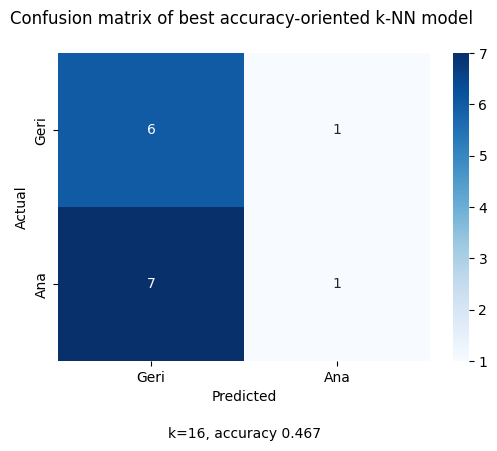

c:\Users\anape\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anape\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anape\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anape\AppData\Local

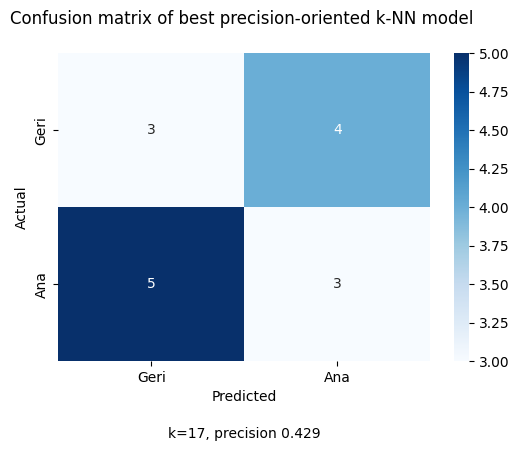

In [14]:
knn_accuracy(X_train, y_train, X_test, y_test)
knn_precision(X_train, y_train, X_test, y_test)

Technically, both models outperform the baseline of 0.4 for each, but not significantly. Practically, looking at the confusion matrices, the predictions are awful.

1. In the accuracy-oriented model, the guesses are almost exclusively one label and the accuracy score reflects the ratio of the two classes in the dataset.

2. In the precision-oriented model, the model more often than not assigns a false positive.

BUT WAIT! If we calculate the precision score for the first, accuracy-oriented confusion matrix, we get $\frac{1}{2} = 0.5$, which is greater than the best precision of 0.429. Why is then the maximum precision 0.429 and not 0.5? The math here is correct, but it is important to remember that **HYPERPARAMETER TUNING IS DONE BASED ON THE TRAINING SET**. The model selection process does not optimize performance in respect to the test set. So, the best precision is 0.429 because we only observe 0.5 after we bring in the test set into the equation, which we do only when the hyperparameters are fixed. 

Overall, these models are not useful for distinguishing between my sister and me. Which is great because now I feel less bad about my own incompetency!

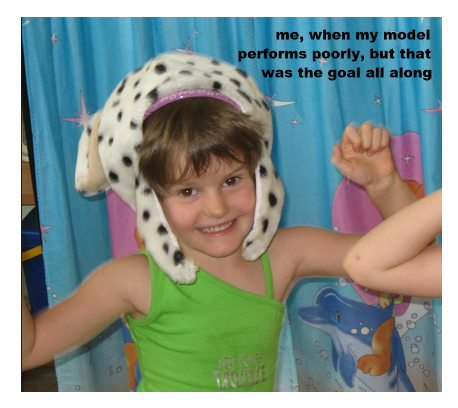

## References


face recognition tools comparison:
https://rupeshthetech.medium.com/face-detection-models-and-their-performance-comparison-eb8da55f328c

dlib installation tutorial:
https://www.geeksforgeeks.org/how-to-install-dlib-library-for-python-in-windows-10/


dlib pre-trained model for placing 68 reference points (shape):
http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 


dlib pre-trained ResNet model for face embeddings by Davis King:
https://github.com/davisking/dlib-models#dlib_face_recognition_resnet_model_v1datbz2